In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from methods.utils import dynamic
from methods import mmca, mcmc
from parameters import Initial_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/inital_data_2.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
features_state = torch.tensor(init_data['init_state'], dtype=torch.float32).to(device)
features_prob = torch.tensor(init_data['init_prob'], dtype=torch.float32).to(device)
P_rows, P_cols = init_data['P_matrix'].nonzero()
P_edge_index = torch.tensor(np.array([P_rows, P_cols]), dtype=torch.long).to(device)
I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

In [3]:
para_len = 100
node_num = features_state.shape[0]

soc_paras_beta_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_beta_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
epi_paras_beta_mmca[...,5] = 0.05

features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)


delta_t = 0.1
mmca_method = mmca.MMCA(device, delta_t)
mcmc_method = mcmc.MCMC(para_len, node_num, device, delta_t)
time_scale = int(50/delta_t)

_, features_phase = dynamic(time_scale, mmca_method, features_state_tensor.clone(), epi_paras_beta_mmca,\
                                 soc_paras_beta_mmca, P_edge_index, I_edge_index, device)
torch.save(features_phase.cpu(), 'data/features_phase.pt')

In [4]:
degree_phase = torch.load('data/features_phase.pt')

def nodes_degrees(min_degree, max_degree, P_edge_index, I_edge_index, degree_phase):
    degreesP = torch.bincount(P_edge_index[0]).cpu()
    degreesI = torch.bincount(I_edge_index[0]).cpu()
    degs = range(min_degree, max_degree + 1)
    features_degree = torch.zeros(degree_phase.shape[0], len(degs), len(degs), 5).cpu()
    for d1 in range(len(degs)):
        for d2 in range(len(degs)):
            # 筛选满足 (d1, d2) 的节点
            mask = (degreesP == degs[d1]) & (degreesI == degs[d2])
            features_degree[:,d1,d2,:] = torch.mean(degree_phase[:,mask,:], dim = 1)
    return features_degree
min_degree, max_degree = 3, 10
features_degree =  nodes_degrees(min_degree, max_degree, P_edge_index, I_edge_index, degree_phase)

print(torch.sum(features_degree[1,:,:,[2,3,4]],dim=-1))

tensor([[0.2970, 0.2720, 0.2539, 0.2319, 0.2222, 0.2133, 0.2087, 0.2050],
        [0.3376, 0.3152, 0.2858, 0.2708, 0.2623, 0.2516, 0.2631, 0.2437],
        [0.3762, 0.3492, 0.3275, 0.3013, 0.2879, 0.2954, 0.2807, 0.2808],
        [0.4070, 0.3787, 0.3598, 0.3460, 0.3319, 0.3296, 0.3193, 0.3284],
        [0.4373, 0.4067, 0.3875, 0.3640, 0.3548, 0.3358, 0.3354, 0.3219],
        [0.4562, 0.4218, 0.4025, 0.3988, 0.3870, 0.3887, 0.3726, 0.3447],
        [0.4886, 0.4556, 0.4485, 0.4158, 0.4079, 0.3893, 0.3879, 0.3565],
        [0.5051, 0.4808, 0.4641, 0.4410, 0.4254, 0.4051, 0.4030, 0.4081]])


C:\Users\95406\AppData\Local\Temp\ipykernel_39520\3794936959.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  degree_phase = torch.load('data/features_phase.pt')


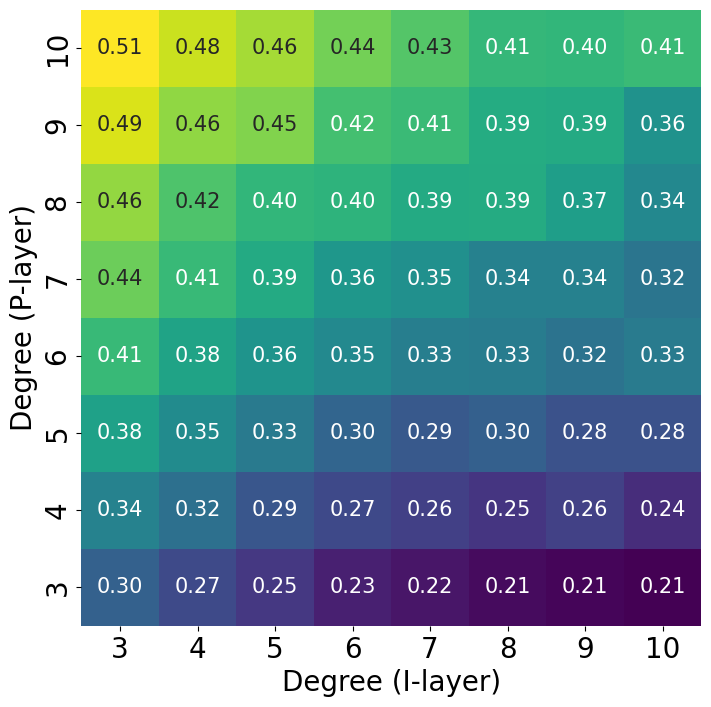

In [9]:
# 将张量转换为 NumPy 数组
data_np = torch.sum(features_degree[1,:,:,[2,3,4]],dim=-1).numpy()
data_np = data_np[::-1]
# 创建热图
plt.figure(figsize=(8, 8))
x_labels = range(min_degree, max_degree + 1)  # 横坐标标签
y_labels = range(min_degree, max_degree + 1)[::-1]  # 纵坐标标签

sns.heatmap(data_np, annot=True, fmt=".2f", cmap="viridis", linewidths=0.0,\
             xticklabels=x_labels, yticklabels=y_labels,
             vmin=np.nanmin(data_np), vmax=np.nanmax(data_np), cbar=False,
             annot_kws={"size": 15})
# 设置标题和标签
# plt.title("Heatmap of Tensor Data", fontsize=16)
plt.xlabel("Degree (I-layer)", fontsize=20)
plt.ylabel("Degree (P-layer)", fontsize=20)
plt.xticks(fontsize=20)  # 增大横坐标刻度大小
plt.yticks(fontsize=20)  # 增大纵坐标刻度大小
# 显示热图
plt.savefig(f'../figs/DegreeResults/degree_heatmap.svg', bbox_inches='tight')
plt.savefig(f'../figs/DegreeResults/degree_heatmap.png', dpi=600)

In [10]:
kog_kogx0_degree_phase = torch.load('data/features_phase.pt')

def nodes_degrees(min_degree, max_degree, P_edge_index, I_edge_index, kog_kogx0_degree_phase):
    degreesP = torch.bincount(P_edge_index[0]).cpu()
    degreesI = torch.bincount(I_edge_index[0]).cpu()
    degs = range(min_degree, max_degree + 1)
    features_degree_P = torch.zeros(kog_kogx0_degree_phase.shape[0], len(degs), 5).cpu()
    features_degree_I = torch.zeros(kog_kogx0_degree_phase.shape[0], len(degs), 5).cpu()
    for d in range(len(degs)):
        mask_P = (degreesP == degs[d])
        features_degree_P[:,d,:] = torch.mean(kog_kogx0_degree_phase[:,mask_P,:], dim = 1)
        mask_I = (degreesI == degs[d])
        features_degree_I[:,d,:] = torch.mean(kog_kogx0_degree_phase[:,mask_I,:], dim = 1)
    return features_degree_P, features_degree_I
min_degree, max_degree = 3, 10
features_degree_P, features_degree_I =  nodes_degrees(min_degree, max_degree, P_edge_index, I_edge_index, kog_kogx0_degree_phase)

C:\Users\95406\AppData\Local\Temp\ipykernel_39520\2976973591.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kog_kogx0_degree_phase = torch.load('data/features_phase.pt'

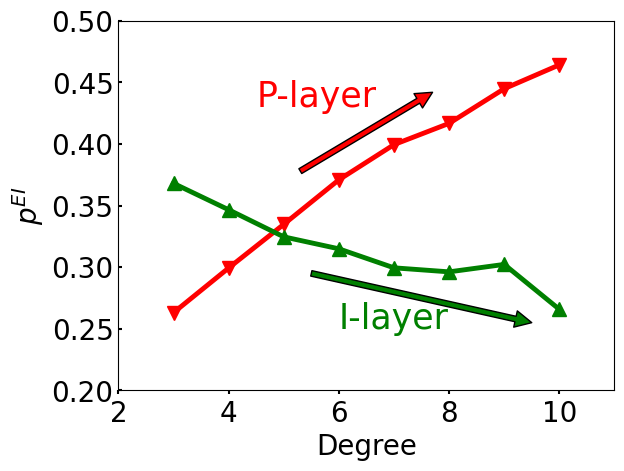

In [11]:
# 将张量转换为 NumPy 数组

degree_data = range(min_degree, max_degree + 1)
data1_P = torch.sum(features_degree_P[0,:,[2,3,4]],dim=-1).numpy()
data1_I = torch.sum(features_degree_I[0,:,[2,3,4]],dim=-1).numpy()


fig, ax = plt.subplots()

plt.plot(degree_data, data1_P, linestyle='-', linewidth=3.5, marker='v', markersize=10,  c='red',  label=f'P-layer') 
plt.plot(degree_data, data1_I, linestyle='-', linewidth=3.5, marker='^', markersize=10,  c='green',  label=f'I-layer') 

# 添加文本标签
# ax.text(10, 0.77250, r'$p_{EI}$', fontsize=25, color='purple')

# 设置坐标轴标签
ax.set_xlabel('Degree', fontsize=20, color='black')
ax.set_ylabel(r'$p^{EI}$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
ax.set_xlim(min(degree_data)-1, max(degree_data)+1)
ax.set_ylim(0.2, 0.5)

# ax.legend(fontsize=15, handlelength=2, handleheight=2)

ax.annotate('', xy=(8, 0.45), xytext=(5, 0.37),
            arrowprops=dict(facecolor='red', shrink=0.1))
ax.text(4.5, 0.43, 'P-layer', fontsize=25, color='red')

ax.annotate('', xy=(10, 0.25), xytext=(5, 0.30),
            arrowprops=dict(facecolor='green', shrink=0.1))
ax.text(6, 0.25, 'I-layer', fontsize=25, color='green')
# 显示图形
plt.show()

fig.savefig(f'../figs/DegreeResults/features_degrees.svg', bbox_inches='tight')